# Lectura y tratamiento de datos

Los datos se extraen de una base de datos InfluxDB, mediante las consultas pertinentes, y se vuelcan a un archivo de tipo csv.

In [1]:
# Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Importar datos

df = pd.read_csv('../data/2023-11-18-18-52 Chronograf Data.csv')

## EDA / Feature engineering

El análisis de los datos se puede encontrar en el EDA que presenté

In [3]:
df.head()

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
0,2022-10-31T00:00:00.000+01:00,541.115,23.550000,16.3,0.21445
1,2022-10-31T01:00:00.000+01:00,541.135,23.800000,15.6,0.20656
2,2022-10-31T02:00:00.000+01:00,541.155,23.733333,15.0,0.17392
3,2022-10-31T03:00:00.000+01:00,541.175,23.800000,14.8,0.17453
4,2022-10-31T04:00:00.000+01:00,541.195,23.650000,15.9,0.17423


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              3647 non-null   object 
 1   kWh.mean_value    2862 non-null   float64
 2   °C.mean_value     3581 non-null   float64
 3   °C.mean_value_2   3382 non-null   float64
 4   €/kWh.mean_value  3636 non-null   float64
dtypes: float64(4), object(1)
memory usage: 142.6+ KB


In [5]:
# Renombrar columnas

df.rename(columns= {'kWh.mean_value': 'kWh', '°C.mean_value': 'temp_int', \
                    '°C.mean_value_2': 'temp_ext', '€/kWh.mean_value': '€/kWh'}, inplace= True)

In [6]:
# Timestamps a formato tiempo

df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S.%f%z', utc= True)

In [7]:
# Tratamiento de NaN (del EDA)

df['€/kWh'].ffill(axis = 0, inplace= True)
df['temp_int'].ffill(axis= 0, inplace= True)
df['temp_ext'].interpolate(method='linear', limit_direction='forward', axis = 0, inplace=True)
df['kWh'].ffill(axis= 0, inplace= True)
df['kWh'].bfill(axis= 0, inplace= True)

In [8]:
# Generar columnas adicionales

df['consumo'] = df['kWh'].diff()
df['€/h'] = df['€/kWh'] * df['consumo']

In [9]:
df.head()

,time,kWh,temp_int,temp_ext,€/kWh,consumo,€/h
0,2022-10-30 23:00:00+00:00,541.115,23.550000,16.3,0.21445,NaN,NaN
1,2022-10-31 00:00:00+00:00,541.135,23.800000,15.6,0.20656,0.02,0.004131
2,2022-10-31 01:00:00+00:00,541.155,23.733333,15.0,0.17392,0.02,0.003478
3,2022-10-31 02:00:00+00:00,541.175,23.800000,14.8,0.17453,0.02,0.003491
4,2022-10-31 03:00:00+00:00,541.195,23.650000,15.9,0.17423,0.02,0.003485


In [10]:
# Pasar filas a columnas

for i in range(24,0,-1):
    df['t_ext-'+str(i)] = df['temp_ext'].shift(i)

In [11]:
for i in range(24,0,-1):
    df['t_int-'+str(i)] = df['temp_int'].shift(i)

In [12]:
for i in range(24,0,-1):
    df['€/kWh-'+str(i)] = df['€/kWh'].shift(i)

In [13]:
# df['€/dia'] = df['€/h'].groupby(df['time'].dt.date).transform('sum')

In [14]:
df['€/dia'] = df['€/h'].rolling(window=24, min_periods=1).sum()

In [15]:
df.head()

,time,kWh,temp_int,temp_ext,€/kWh,consumo,€/h,t_ext-24,t_ext-23,t_ext-22,...,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1,€/dia
0,2022-10-30 23:00:00+00:00,541.115,23.550000,16.3,0.21445,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-31 00:00:00+00:00,541.135,23.800000,15.6,0.20656,0.02,0.004131,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21445,0.004131
2,2022-10-31 01:00:00+00:00,541.155,23.733333,15.0,0.17392,0.02,0.003478,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21445,0.20656,0.007610
3,2022-10-31 02:00:00+00:00,541.175,23.800000,14.8,0.17453,0.02,0.003491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.21445,0.20656,0.17392,0.011100
4,2022-10-31 03:00:00+00:00,541.195,23.650000,15.9,0.17423,0.02,0.003485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.21445,0.20656,0.17392,0.17453,0.014585


In [16]:
df2 = df.copy()
df3 = df.iloc[1::24].copy()

In [17]:
df2.dropna(axis= 0, how= 'any', inplace= True)
df3.dropna(axis= 0, how= 'any', inplace= True)

In [18]:
df2.drop(columns=['kWh', 'temp_int', 'temp_ext', '€/kWh', 'consumo', '€/h', 'time'], inplace= True)
df3.drop(columns=['kWh', 'temp_int', 'temp_ext', '€/kWh', 'consumo', '€/h', 'time'], inplace= True)

In [19]:
# df2.reset_index(inplace= True)
# df3.reset_index(inplace= True)

In [20]:
df2.head()

,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,t_ext-15,...,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1,€/dia
24,16.3,15.6,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,...,0.24425,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.025415
25,15.6,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,...,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.021284
26,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,...,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.017806
27,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,20.2,...,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.16898,0.014315
28,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,20.2,23.1,...,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.16898,0.16923,0.010831


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3623 entries, 24 to 3646
Data columns (total 73 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t_ext-24  3623 non-null   float64
 1   t_ext-23  3623 non-null   float64
 2   t_ext-22  3623 non-null   float64
 3   t_ext-21  3623 non-null   float64
 4   t_ext-20  3623 non-null   float64
 5   t_ext-19  3623 non-null   float64
 6   t_ext-18  3623 non-null   float64
 7   t_ext-17  3623 non-null   float64
 8   t_ext-16  3623 non-null   float64
 9   t_ext-15  3623 non-null   float64
 10  t_ext-14  3623 non-null   float64
 11  t_ext-13  3623 non-null   float64
 12  t_ext-12  3623 non-null   float64
 13  t_ext-11  3623 non-null   float64
 14  t_ext-10  3623 non-null   float64
 15  t_ext-9   3623 non-null   float64
 16  t_ext-8   3623 non-null   float64
 17  t_ext-7   3623 non-null   float64
 18  t_ext-6   3623 non-null   float64
 19  t_ext-5   3623 non-null   float64
 20  t_ext-4   3623 non-null   flo

''

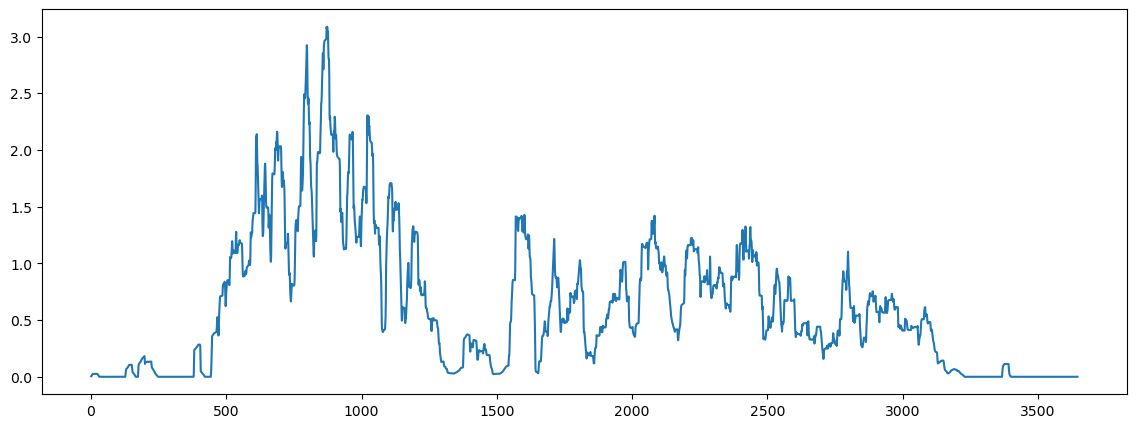

In [22]:
# Gráfico del target

plt.figure(figsize= (14, 5))
plt.plot(df['€/dia'])
;

''

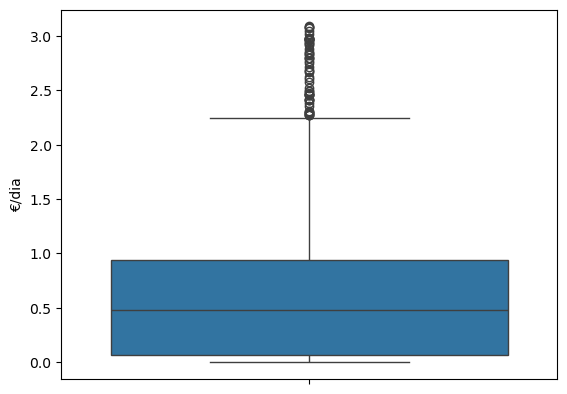

In [33]:
sns.boxplot(df['€/dia'])
;

## Train / test split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = df2.drop(columns= '€/dia')
Y = df2['€/dia']

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size= 0.20,
                                                    random_state= 51)

In [26]:
train = X_train.copy()
train['€/dia'] = Y_train
train.head()

,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,t_ext-15,...,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1,€/dia
2292,9.0,10.70,11.5,11.45,11.4,10.70,9.3,7.5,6.6,5.0,...,0.15313,0.15095,0.15447,0.17526,0.19609,0.23845,0.22639,0.25571,0.24697,0.732918
1100,16.9,17.05,17.2,16.80,14.6,13.10,12.8,12.3,11.8,11.5,...,0.29284,0.29494,0.29446,0.24578,0.25021,0.25535,0.27992,0.34162,0.37789,1.592694
2306,1.3,1.00,0.1,-0.20,-0.6,-0.55,-0.5,-0.3,0.7,3.5,...,0.20965,0.27650,0.30941,0.29570,0.27028,0.22400,0.22002,0.20876,0.20196,0.804648
3042,12.2,10.10,8.2,7.00,5.4,4.60,3.6,3.4,4.1,4.9,...,0.21772,0.26296,0.26524,0.26225,0.25623,0.20929,0.21233,0.21599,0.21946,0.436875
1193,16.1,15.70,15.2,15.60,15.9,16.00,15.8,15.2,14.3,13.5,...,0.18025,0.17599,0.19805,0.19563,0.19563,0.19359,0.14655,0.14869,0.17204,1.233529


In [27]:
test = X_test.copy()
test['€/dia'] = Y_test
test.head()

,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,t_ext-15,...,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1,€/dia
1893,8.7,9.1,9.5,12.3,9.60,9.1,11.9,12.1,10.70,9.4,...,0.09584,0.09653,0.05086,0.05094,0.05442,0.05347,0.09723,0.10660,0.11275,0.430984
3336,12.7,16.1,15.2,15.1,14.90,14.7,14.5,13.0,13.45,15.2,...,0.10782,0.11657,0.14028,0.15788,0.17189,0.19097,0.17801,0.17509,0.16209,0.000000
1271,14.2,12.5,12.1,11.5,10.40,12.4,12.3,13.6,16.00,16.4,...,0.10157,0.10357,0.12105,0.12134,0.18311,0.18617,0.18685,0.18467,0.12349,0.499150
2617,6.2,5.8,4.9,4.6,4.20,3.5,3.8,3.3,4.20,7.5,...,0.19826,0.21753,0.27290,0.28410,0.27514,0.26798,0.21351,0.18971,0.16245,0.376684
2566,13.2,13.0,12.5,11.1,9.95,8.8,11.0,9.0,9.50,9.1,...,0.23627,0.18979,0.19377,0.20484,0.21203,0.26909,0.28644,0.28827,0.27578,0.672029


In [28]:
# train.to_csv('../data/train.csv')

In [29]:
# test.to_csv('../data/test.csv')

In [30]:
# df3.to_csv('../data/test_dias_naturales.csv')